# DQN训练演示

本notebook演示如何使用清理后的DQN结构进行训练

In [ ]:
# GPU优化配置 - 必须在导入其他模块前配置
import os
import tensorflow as tf

# 1. 启用XLA编译优化 (5-15% 性能提升)
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'
tf.config.optimizer.set_jit(True)

# 2. 配置GPU内存增长,防止OOM
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ 配置了 {len(gpus)} 个GPU,启用内存增长和XLA编译")
    except RuntimeError as e:
        print(f"⚠️  GPU配置警告: {e}")
else:
    print("⚠️  未检测到GPU,将在CPU上运行")

# 3. 其他性能优化
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 减少日志输出
tf.config.threading.set_inter_op_parallelism_threads(0)  # 自动配置
tf.config.threading.set_intra_op_parallelism_threads(0)

# 导入必要的库
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from trainer import Trainer
from config.train import TrainingConfig
from config.network import NetworkConfig
from policy.dqn import DQNPolicy
from model.dqn_mlp import DeepQNetworkModel
from agent.kytolly import KytollyAgent
import sys

print("✅ GPU优化配置完成")

In [2]:
# 将项目根目录添加到 Python 路径中，以确保所有模块都能被可靠地导入
# 这是一个良好的实践，可以避免很多导入问题
if '.' not in sys.path:
    sys.path.append('.')

## 1. 配置训练参数

--- 正在从绝对路径加载配置文件: /home/fangsuo/py/DRL-Baselines/config/hp_base.yml ---
--- 配置文件加载成功! ---

📊 训练参数:


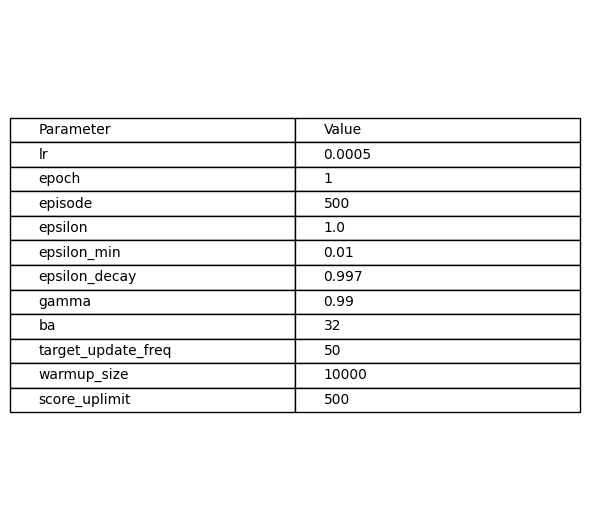

In [3]:
# --- 1. 使用正确的路径和文件名加载配置 ---

# 获取当前工作目录（也就是您的项目根目录）
PROJECT_ROOT = os.getcwd()

FILENAME = 'hp_base.yml'
CONFIG_PATH = os.path.join(PROJECT_ROOT, 'config', FILENAME)

print(f"--- 正在从绝对路径加载配置文件: {CONFIG_PATH} ---")

try:
    # 传递正确的、绝对的路径来加载配置
    train_cfg = TrainingConfig.from_yaml(CONFIG_PATH)
    print("--- 配置文件加载成功! ---")
except FileNotFoundError:
    print(f"错误: 文件 {CONFIG_PATH} 未找到。")
    print("请再次检查 'config' 目录下的文件名是否完全匹配。")
    raise

# 使用表格显示已加载的配置参数
print("\n📊 训练参数:")
train_cfg.table()
plt.show()

## 2. 创建环境和模型

In [ ]:
# --- 2. 创建环境 ---
env = gym.make('CartPole-v1')
print(f"\n✅ 环境: {env.spec.id}")
print(f"   状态空间: {env.observation_space.shape}")
print(f"   动作空间: {env.action_space.n}")

# --- 3. 创建DQN网络配置和模型 ---
dqn_cfg = NetworkConfig(hidden_dims=[128, 128], metrics=['mse'], lr=train_cfg.lr)
dqn_model = DeepQNetworkModel(dqn_cfg)
print(f"\n✅ DQN模型创建完成")
dqn_model.summary()

In [ ]:
# --- 4. 创建策略和Agent ---
# 定义日志目录
log_dir = 'logs/dqn_notebook'
os.makedirs(log_dir, exist_ok=True)

# 检测GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    device = '/GPU:0'
    print(f"✅ 检测到 {len(gpus)} 个GPU，将使用GPU训练")
else:
    device = 'auto'
    print("⚠️  未检测到GPU，将使用CPU训练")

# 创建TensorBoard回调
cb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# 创建DQN策略和Agent
dqn_policy = DQNPolicy(model=dqn_model, device=device)
dqn_agent = KytollyAgent(env, dqn_policy, train_cfg, cb, device=device)

print(f"\n✅ DQN Agent初始化完成")
print(f"   使用设备: {device}")
print(f"   日志目录: {log_dir}")

## 3. 启动TensorBoard实时监控

在开始训练前,启动TensorBoard以实时查看训练进度。

有两种方式:
1. **独立窗口**: 在终端运行 `tensorboard --logdir=logs/` （推荐）
2. **远程服务器**: 使用SSH端口转发

In [ ]:
# TensorBoard实时监控
# 
# 由于notebook内嵌TensorBoard可能不稳定，建议在终端单独启动：
# 
# 方法1: 在终端运行（推荐）
# ```bash
# tensorboard --logdir=logs/ --port=6006
# ```
# 然后在浏览器访问: http://localhost:6006
#
# 方法2: 如果在远程服务器，使用SSH端口转发
# 本地机器运行: ssh -L 6006:localhost:6006 user@server_ip
# 服务器运行: tensorboard --logdir=logs/ --port=6006
# 本地浏览器访问: http://localhost:6006

print("💡 提示: 请在终端运行以下命令启动TensorBoard:")
print("   tensorboard --logdir=logs/ --port=6006")
print("\n然后在浏览器访问: http://localhost:6006")
print("\n训练开始后，TensorBoard会实时更新以下指标:")
print("  - Training/Episode_Total_Reward")
print("  - Training/Batch_Loss")
print("  - Evaluation/Reward_Mean")
print("  - Evaluation/Reward_Variance")

## 4. 开始训练

In [ ]:
print("\n🚀 开始GPU加速的DQN训练...")
print("=" * 60)
print("性能优化已启用:")
print("  ✓ GPU常驻张量的Replay Buffer (减少60-80% CPU-GPU传输)")
print("  ✓ XLA编译优化 (提升5-15% 计算速度)")
print("  ✓ 优化的Target网络同步 (减少90% 同步时间)")
print("  ✓ GPU内存按需增长")
print("  ✓ TensorBoard实时监控")
print("=" * 60)
print("\n💡 提示: 在终端运行 'tensorboard --logdir=logs/' 实时监控训练进度\n")

# 开始训练
dqn_agent.learn()

print("\n🎉 DQN训练完成！")

## 5. 保存完整的训练数据和模型

In [ ]:
# 创建保存目录
save_dir = 'results/dqn/8'
os.makedirs(save_dir, exist_ok=True)

print("📦 正在保存训练数据和模型...")
print("=" * 60)

# 1. 保存训练数据 (data.json)
import json
data = {
    'train_reward_lst': dqn_agent.train_reward_lst,
    'eval_reward_mean_lst': dqn_agent.eval_reward_mean_lst,
    'eval_reward_var_lst': dqn_agent.eval_reward_var_lst
}
with open(f'{save_dir}/data.json', 'w', encoding='utf-8') as f:
    json.dump(data, f, indent=2)
print(f"✅ 训练数据已保存: {save_dir}/data.json")

# 2. 保存模型权重
dqn_model.save(f'{save_dir}/model')
print(f"✅ 模型权重已保存:")
print(f"   - {save_dir}/model_online.h5")
print(f"   - {save_dir}/model_target.h5")

# 3. 保存配置图表
fig0, ax0 = dqn_cfg.table()
fig0.savefig(f'{save_dir}/online_ddqn_cfg.png', dpi=100, bbox_inches='tight')
plt.close(fig0)
print(f"✅ 网络配置图表已保存: {save_dir}/online_ddqn_cfg.png")

fig1, ax1 = train_cfg.table()
fig1.savefig(f'{save_dir}/train_cfg.png', dpi=100, bbox_inches='tight')
plt.close(fig1)
print(f"✅ 训练配置图表已保存: {save_dir}/train_cfg.png")

# 4. 保存训练结果图表
fig2, ax2 = dqn_agent.plot_smoothed_training_rwd()
fig2.savefig(f'{save_dir}/plot_smoothed_training_rwd.png', dpi=100, bbox_inches='tight')
plt.close(fig2)
print(f"✅ 训练奖励图表已保存: {save_dir}/plot_smoothed_training_rwd.png")

fig3, ax3 = dqn_agent.plot_eval_rwd_var()
fig3.savefig(f'{save_dir}/plot_eval_rwd_var.png', dpi=100, bbox_inches='tight')
plt.close(fig3)
print(f"✅ 评估方差图表已保存: {save_dir}/plot_eval_rwd_var.png")

print("=" * 60)
print(f"🎉 所有文件已保存到目录: {save_dir}/")
print("\n📋 保存的文件列表:")
print(f"  - data.json               (训练数据)")
print(f"  - model_online.h5         (在线网络权重)")
print(f"  - model_target.h5         (目标网络权重)")
print(f"  - online_ddqn_cfg.png     (网络配置)")
print(f"  - train_cfg.png           (训练配置)")
print(f"  - plot_smoothed_training_rwd.png  (训练奖励曲线)")
print(f"  - plot_eval_rwd_var.png   (评估方差曲线)")

In [ ]:
# 关闭环境
env.close()
print("🎯 训练会话结束！")
print(f"\n📊 查看TensorBoard日志: tensorboard --logdir={log_dir}")
print(f"📁 查看保存的文件: ls -lh {save_dir}/")